In [ ]:
# Install dlroms if needed

# try:
#      from dlroms import *
# except:
#      !pip install git+https://github.com/NicolaRFranco/dlroms.git
#      from dlroms import *

In [ ]:
# Import libraries

import numpy as np
from dlroms import *
from dlroms.dnns import *
from dlroms.roms import *
import numpy.random as rnd
import matplotlib.pyplot as plt
import torch
from dolfin import *
import time

In [ ]:
# Read files from Google Drive

# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# %cd "./gdrive/MyDrive/DL-ROMs/high-fidelity"

In [ ]:
# %cd "./gdrive/MyDrive/Colab Notebooks/DL-ROMs/high-fidelity"

/content/gdrive/MyDrive/Colab Notebooks/DL-ROMs/high-fidelity


In [ ]:
# Flags

useGPU = True

if useGPU:
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Random seeds

rnd.seed(0)
torch.manual_seed(0)

In [ ]:
# Domain and mesh definition

h = 0.01 													          																		# Mesh size
n = 100												              																		# Number of cells (1/h)

# Generate mesh with gmsh
# D = fe.rectangle((0,0), (1,1)) 																								# Square domain
# mesh = fe.mesh(D, stepsize=h) 																								# Mesh (stepsize parameter available with gmsh)

# Generate mesh with FEniCS
mesh = fe.unitsquaremesh(n, n)																									# Mesh

V = fe.space(mesh, 'CG', 1) 																										# Continuous piecewise linear finite elements
Nh = V.dim() 												        																		# Space dimension (number of dofs)

In [ ]:
# Load snapshots

training_size = 1200
test_size = 5000

mu_train = np.load('mu_train_'+str(training_size)+'.npy')
mu_test = np.load('mu_test.npy')
u_train = np.load('u_train_'+str(training_size)+'.npy')
u_test = np.load('u_test.npy')

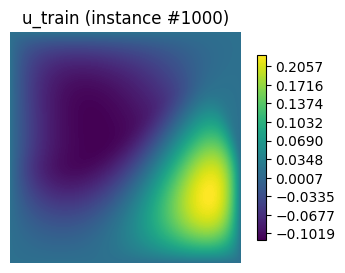

In [ ]:
# Print snapshot

index = 1000

plt.figure(figsize=(4, 3))
fe.plot(u_train[index, :], V, colorbar=True)
plt.title('u_train (instance #' + str(index) + ')')
plt.show()

In [ ]:
# Traning architecture

m = 16																																					# Decoder
k = 4																																						# Dense NN

torch.set_default_dtype(torch.float32)

psi_prime = Dense(Nh, 4, activation=None)

psi = Dense(4, 100 * m) + \
			Reshape(4 * m, 5, 5) + \
			Deconv2D(11, (4 * m, 2 * m), 2) + \
			Deconv2D(10, (2 * m, m), 2) + \
			Deconv2D(11, (m, 1), 2, activation=None) + \
			Reshape(-1)

phi = Dense(4, 50 * k) + \
			Dense(50 * k, 50 * k) + \
			Dense(50 * k, 4, activation=None)

print("Trainable parameters:")
print(" Encoder:", psi_prime.dof())
print(" Decoder:", psi.dof())
print(" Dense NN:", phi.dof())

Trainable parameters:
 Encoder: 40808
 Decoder: 308993
 Dense NN: 42004


In [ ]:
# Convert NumPy arrays to tensors on the selected device

u_train = torch.tensor(u_train, dtype=torch.float32).to(device)
u_test = torch.tensor(u_test, dtype=torch.float32).to(device)
mu_train = torch.tensor(mu_train, dtype=torch.float32).to(device)
mu_test = torch.tensor(mu_test, dtype=torch.float32).to(device)

In [ ]:
# TRAIN THE COMPLETE DLROM MODEL

dlrom = DLROM(phi, psi, psi_prime)                                              # Dense NN, decoder, encoder

dlrom.to(device)

def loss(true, predicted):
  utrue = true
  upred, delta_latent, urecon = predicted                                       # Unpack the prediction into predicted solution, latent representation error, and reconstructed solution
  return mse(neuclidean)(utrue, upred) + mse(neuclidean)(utrue, urecon) + mse(neuclidean)(0, delta_latent) # l2?

def error(true, predicted):
  utrue = true
  upred, delta_latent, urecon = predicted
  return mse(neuclidean)(utrue, upred)

dlrom.train((mu_train, u_train), u_train, ntrain=training_size, epochs=300, loss=loss, error=error, verbose=True)

		Train		Test
Epoch 300:	3.68e-05	nan.

>> ETA: 5.83s.

Training complete. Elapsed time: 29 minutes 8.22 seconds.


In [ ]:
# DLROM loss (T4 GPU, 1200, epochs=200): 4.71e-05
# DLROM training time (T4 GPU, 1200, epochs=200): 19m 31s
# DLROM loss (T4 GPU, 1200, epochs=300): 3.68e-05
# DLROM training time (T4 GPU, 1200, epochs=300): 29m 8s

In [ ]:
# Use the DLROM to predict the full order solution

dlrom.eval()

with torch.no_grad():
  u_train_pred = dlrom(mu_train)

In [ ]:
# Compute the relative error

error_train = torch.norm(u_train - u_train_pred, dim=1) / torch.norm(u_train, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))

Relative training error: 7.10%


In [ ]:
# Relative training error (1200, epochs=200): 7.94%
# Relative training error (1200, epochs=300): 7.10%

In [ ]:
# Apply the model to the test set

with torch.no_grad():
  u_test_pred = dlrom(mu_test)

error_test = torch.norm(u_test - u_test_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative test error: 7.57%


In [ ]:
# Relative test error (1200, epochs=200): 8.35%
# Relative test error (1200, epochs=300): 7.57%

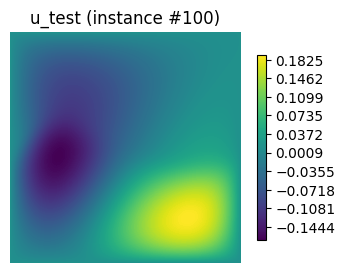

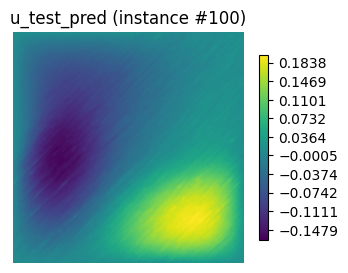

In [ ]:
# Plot some results

index = 100

plt.figure(figsize=(4, 3))
fe.plot(u_test[index, :], V, colorbar=True)
plt.title('u_test (instance #' + str(index) + ')')

plt.figure(figsize=(4, 3))
fe.plot(u_test_pred[index, :], V, colorbar=True)
plt.title('u_test_pred (instance #' + str(index) + ')')

plt.show()